In [1]:
import functools
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, kstest
from itertools import combinations

# libraries related to plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Arial'})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
combo=3

In [5]:
meta_outfile = f"/data5/deepro/ukbiobank/analysis/bmi_project/lifestyle_factors/data/meta_rarecomb_out_{combo}.csv"
meta_infile = "/data5/deepro/ukbiobank/analysis/bmi_project/lifestyle_factors/data/meta_rarecomb_in.csv"
case_sample_file = "/data5/UK_Biobank/bmi_project/combinations/white_british/cases_controls/high_low_cases.txt"
variants_file = "/data5/UK_Biobank/annotations/vep/2022_03_13/data/variants_by_gene/lof_missense_pred_freq_0.01.tsv"
phenotypes_file = "/data5/UK_Biobank/bmi_project/combinations/all_combinations/sample_tables/white_british_samples_with_residuals.csv"
wes_file = "/data5/UK_Biobank/bmi_project/combinations/white_british/tables/wes.tsv"
lifestyle_factor_files = [
    "/data5/deepro/ukbiobank/analysis/bmi_project/lifestyle_factors/data/mental_health/cat_extremes.csv",
    "/data5/deepro/ukbiobank/analysis/bmi_project/lifestyle_factors/data/diet/cat_extremes.csv",
    "/data5/deepro/ukbiobank/analysis/bmi_project/lifestyle_factors/data/physical_activity/cat_extremes.csv"
]

# Combinations that were significant

In [6]:
rarecomb_out = pd.read_csv(meta_outfile)
rarecomb_out_sig = rarecomb_out.loc[rarecomb_out.Case_Adj_Pval_BH<0.05]

In [7]:
def create_plot_df(profile_df, conds, cond_cats=["genes only", "lifestyles only", "combos", "no gene or lifestyle"]):
    plot_df = pd.DataFrame()
    for cond, condcat in zip(conds, cond_cats):
        pltdf = profile_df.loc[profile_df.eval(cond), "bmi"].to_frame()
        pltdf["category"] = condcat
        plot_df = pd.concat((plot_df, pltdf))
    return plot_df

def create_separate_plot_df(rarecomb_out_sig, lifestyle_of_interest):
    # filter based on lifestyle of interest
    rarecomb_out_sig = rarecomb_out_sig.loc[(
    (rarecomb_out_sig.Item_1.str.contains(lifestyle_of_interest)) | 
    (rarecomb_out_sig.Item_2.str.contains(lifestyle_of_interest)) | 
    (rarecomb_out_sig.Item_3.str.contains(lifestyle_of_interest))
    )]
    # get unique items that came out of the enriched combinations
    enriched_combos = rarecomb_out_sig.loc[:, [f"Item_{c}" for c in range(1, combo+1)]].values
    columns_to_use = sorted(set(enriched_combos.flatten()))
    gene_columns_to_use = [c for c in columns_to_use if "_ENSG" in c]
    lifestyle_columns_to_use = [c for c in columns_to_use if "_ENSG" not in c]
    # get wes data on samples with these gene columns
    wes_df = pd.read_csv(wes_file, sep="\t", low_memory=False, usecols=["Sample_Name"] + gene_columns_to_use, index_col=0)
    # get data on samples with these lifestyle factors
    lifestyle_df = pd.concat([pd.read_csv(lf, index_col=0) for lf in lifestyle_factor_files], axis=1).fillna(0.)
    # get the bmi of these samples
    phenotypes_df = pd.read_csv(phenotypes_file, low_memory=False, usecols=["eid", "bmi"], index_col=0, dtype={"eid": str, "bmi": np.float64})
    gene_df = wes_df.merge(phenotypes_df, left_index=True, right_index=True)
    profile_df = lifestyle_df.merge(gene_df, left_index=True, right_index=True)
    # Filter samples based on conditions
    # The conditions are:
    # 1. Samples who have any one of the genes but not the lifestyle factors
    # 2. Samples who have any one of the lifestyle factors but not the genes
    # 3. Samples who have these combinations identified by rarecomb
    # 4. Samples who do not have either the gene or the lifestyle factors
    # condition 1 eval string
    cond1 = "(" + " | ".join([f"({gene} == 1)" for gene in gene_columns_to_use]) + ")" + " & " + "(" + " & ".join([f"({lf} == 0)" for lf in lifestyle_columns_to_use]) + ")"
    # condition 2 eval string
    cond2 = "(" + " | ".join([f"({lf} == 1)" for lf in lifestyle_columns_to_use]) + ")" + " & " + "(" +" & ".join([f"({gene} == 0)" for gene in gene_columns_to_use]) + ")"
    # condition 3 eval string
    cond3 = " | ".join(["(" + " & ".join([f"({c} == 1)" for c in ec_i]) + ")" for ec_i in enriched_combos])
    # condition 4 eval string
    cond4 = " & ".join([f"({lf_g} == 0)" for lf_g in columns_to_use])  
    # create plot df
    cond_cats = ["genes only", f"{lifestyle_of_interest} lifestyles only", "combos", "no gene or lifestyle"]
    plot_df = create_plot_df(profile_df, [cond1, cond2, cond3, cond4], cond_cats)
    return plot_df, cond_cats

In [8]:
mental_health_plot_df, mental_health_cond_cats = create_separate_plot_df(rarecomb_out_sig, "mental_health")

In [9]:
physical_activity_plot_df, physical_activity_cond_cats = create_separate_plot_df(rarecomb_out_sig, "physical_activity")

In [10]:
diet_plot_df, diet_cond_cats = create_separate_plot_df(rarecomb_out_sig, "diet")

# Separate violin plots for all

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


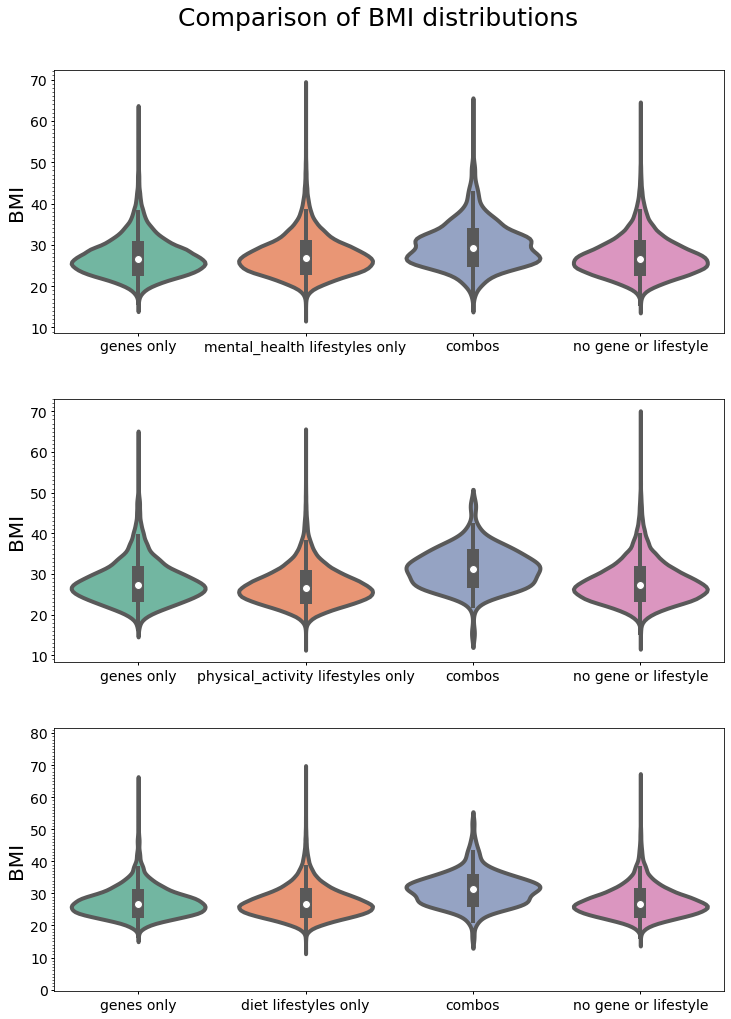

In [12]:
pdf_store = PdfPages('/data5/deepro/ukbiobank/analysis/bmi_project/lifestyle_factors/data/results/figures/violin_separate.pdf')

fig, axes = plt.subplots(3, 1, figsize=(12, 16))
for i, pltdf in enumerate([mental_health_plot_df, physical_activity_plot_df, diet_plot_df]):
    snsax = sns.violinplot(
        data=pltdf, 
        x="category", 
        y="bmi", 
        hue="category", 
        palette="Set2", 
        orient="v",
        ax=axes[i],
        scale="area",
        dodge=False,
        inner="box",
        linewidth=4,
        )
    snsax.legend([], [], frameon=False)
    snsax.yaxis.set_minor_locator(MultipleLocator(1))
    snsax.set_xlabel(None)
    snsax.set_xticklabels(snsax.get_xticklabels(), fontsize=14)
    snsax.tick_params(labelsize=14, width=1, length=3)
    snsax.set_ylabel("BMI", fontsize=20)

fig.suptitle("Comparison of BMI distributions", fontsize=25)
plt.subplots_adjust(hspace = 0.25, top=0.925)
plt.margins(y=0.2)
pdf_store.savefig(fig, bbox_inches='tight')
pdf_store.close()

# Significance test

In [13]:
def run_test(plot_df, cond1, cond2):
    x = plot_df.loc[plot_df.category==cond1].bmi.values
    y = plot_df.loc[plot_df.category==cond2].bmi.values
    ttest_res = ttest_ind(x, y)
    kstest_res = kstest(x, y)
    return f"{cond1} vs {cond2}", ttest_res.pvalue,  kstest_res.pvalue

def run_significant_test(plot_df, cond_cats):
    bmi_dict = {cond_cat:(np.mean(plot_df.loc[plot_df.category==cond_cat].bmi.values), len(plot_df.loc[plot_df.category==cond_cat].bmi.values)) for cond_cat in cond_cats}
    df = pd.DataFrame([run_test(plot_df, c[0], c[1]) for c in list(combinations(cond_cats, 2))], columns=["comparisons", "ttest_pvalue", "kstest_pvalue"]).sort_values("kstest_pvalue")
    return df, bmi_dict

In [14]:
mhdf,mhdict = run_significant_test(mental_health_plot_df, mental_health_cond_cats)
padf,padict = run_significant_test(physical_activity_plot_df, physical_activity_cond_cats)
didf, didict = run_significant_test(diet_plot_df, diet_cond_cats)

In [15]:
mental_health_sig_table = "/data5/deepro/ukbiobank/analysis/bmi_project/lifestyle_factors/data/results/tables/mental_health_significant.csv"
diet_sig_table = "/data5/deepro/ukbiobank/analysis/bmi_project/lifestyle_factors/data/results/tables/diet_significant.csv"
physical_activity_sig_table = "/data5/deepro/ukbiobank/analysis/bmi_project/lifestyle_factors/data/results/tables/physical_activity_significant.csv"


In [16]:
mhdf.to_csv(mental_health_sig_table, index=False)

In [17]:
padf.to_csv(physical_activity_sig_table, index=False)

In [18]:
didf.to_csv(diet_sig_table, index=False)

In [19]:
mhdict

{'genes only': (27.169197934966125, 31194),
 'mental_health lifestyles only': (27.407205353952033, 47756),
 'combos': (29.820046845479084, 2964),
 'no gene or lifestyle': (27.232456841681586, 24017)}

In [20]:
padict

{'genes only': (28.015628557541547, 5315),
 'physical_activity lifestyles only': (27.09376832471548, 103274),
 'combos': (31.355460628019323, 138),
 'no gene or lifestyle': (27.951699913076094, 46209)}

In [21]:
didict

{'genes only': (27.381511455624455, 4999),
 'diet lifestyles only': (27.341198619901554, 113760),
 'combos': (31.35281507490637, 178),
 'no gene or lifestyle': (27.430750186878583, 27558)}

# Extend the significance table to make it better

## Rearrange lifestyle and gene

- Add types to items (types can be either gene or lifestyle)
- Arrangement should be lifestyle first and gene second

In [22]:
relevant_columns = [
    "Item_1", 
    "Item_2",
    "Item_3",
    "Case_Obs_Count_Combo",
    "Case_Exp_Prob_Combo",
    "Case_Obs_Prob_Combo",
    "Case_pvalue_more",
    "Case_Adj_Pval_bonf",
    "Case_Adj_Pval_BH"
    ]

rarecomb_out_sig_filtered = rarecomb_out_sig.loc[:, relevant_columns]

In [23]:
rarecomb_out_sig_filtered["combo_num"] = list(range(1, len(rarecomb_out_sig_filtered)+1))
rarecomb_out_sig_filtered = rarecomb_out_sig_filtered.set_index("combo_num")

In [24]:
melted_df = pd.melt(rarecomb_out_sig_filtered.reset_index(), id_vars=["combo_num"], value_vars=["Item_1", "Item_2", "Item_3"])
melted_df["type"] = ["gene" if v.startswith("Input_ENSG") else "lifestyle" for v in melted_df.value.values]
melted_df_pivot = melted_df.sort_values(["type", "value"], ascending=False).groupby("combo_num").agg({"value": lambda x: ",".join(x), "type": lambda x: ",".join(x)})
melted_df_pivot_concat = pd.concat((melted_df_pivot.value.str.split(",", expand=True), melted_df_pivot.type.str.split(",", expand=True)), axis=1)
melted_df_pivot_concat.columns = [f"Item_{i}" for i in range(1, combo+1)] + [f"Item_{i}_type" for i in range(1, combo+1)]

In [26]:
rarecomb_out_sig_rearranged = rarecomb_out_sig_filtered.drop(columns=[f"Item_{i}" for i in range(1, combo+1)]).merge(melted_df_pivot_concat, left_index=True, right_index=True)

## Add gene symbols to items

In [27]:
filename = '/data5/bx_reference/hg38/annotations/gene_annotations/GENCODE39/gencode.v39.parsed.genes.tsv'
gencode = pd.read_csv(filename, sep='\t', low_memory=False)
gencode["gene_id_stripped"] = gencode["gene_id"].str.split(".", expand=True)[0]

In [28]:
gene_symbol_dict = dict(zip(gencode.gene_id_stripped, gencode.gene_name))

In [30]:
rarecomb_out_sig_rearranged["Item_1_symbol"] = rarecomb_out_sig_rearranged.apply(lambda row: gene_symbol_dict[row.Item_1.replace("Input_", "")] if row.Item_1.startswith("Input_ENSG") else np.nan, axis=1)
rarecomb_out_sig_rearranged["Item_2_symbol"] = rarecomb_out_sig_rearranged.apply(lambda row: gene_symbol_dict[row.Item_2.replace("Input_", "")] if row.Item_2.startswith("Input_ENSG") else np.nan, axis=1)
rarecomb_out_sig_rearranged["Item_3_symbol"] = rarecomb_out_sig_rearranged.apply(lambda row: gene_symbol_dict[row.Item_3.replace("Input_", "")] if row.Item_3.startswith("Input_ENSG") else np.nan, axis=1)

# Save table

In [35]:
rarecomb_out_sig_rearranged_genes = rarecomb_out_sig_rearranged.loc[rarecomb_out_sig_rearranged.Item_2_type=="gene"]
rarecomb_out_sig_rearranged_lifestyles = rarecomb_out_sig_rearranged.loc[rarecomb_out_sig_rearranged.Item_2_type=="lifestyle"]

In [36]:
def save_table_genes(save_df, filename):
    cdf = pd.DataFrame()
    for g, df in save_df.groupby(["Item_1", "Item_2_symbol"]):
        cdf = pd.concat((cdf, df), axis=0) 
    cdf = cdf.set_index(["Item_1", "Item_2_symbol", "Item_3_symbol"])
    cdf.to_csv(filename)
    return

def save_table_lifestyles(save_df, filename):
    cdf = pd.DataFrame()
    for g, df in save_df.groupby(["Item_1", "Item_2"]):
        cdf = pd.concat((cdf, df), axis=0) 
    cdf = cdf.set_index(["Item_1", "Item_2", "Item_3_symbol"])
    cdf.to_csv(filename)
    return

In [37]:
save_table_genes(rarecomb_out_sig_rearranged_genes, "/data5/deepro/ukbiobank/analysis/lifestyle_factors/data/results/tables/combo3_lf_gene_gene.csv")
save_table_lifestyles(rarecomb_out_sig_rearranged_lifestyles, "/data5/deepro/ukbiobank/analysis/lifestyle_factors/data/results/tables/combo3_lf_lf_gene.csv")